In [1]:
import pandas as pd
import seaborn as sns

# load data and rename columns
d = pd.read_csv('data/creditcard.csv')
d.columns = [col.lower() for col in d.columns]
d = d.rename(columns={
    'default payment next month': 'default', 
    'pay_0': 'pay_1'})

In [2]:
d.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

By definition, column *pay_0* relates to last month, but for the same month serve columns *bill_amt1* and *pay_amt1*. Rename columns *pay_0* to *pay_1* to achieve easier data handling later.

Data Exploration
==============

The following should be done only on train+validation set, not on the whole dataset...

Missing values
---------------------

In [3]:
d.isnull().sum(axis=1).value_counts()

0    23999
dtype: int64

There are no missing values in the dataset.

<AxesSubplot:title={'center':'Credit card default (0: not-bdefault, 1: default)'}, xlabel='default', ylabel='count'>

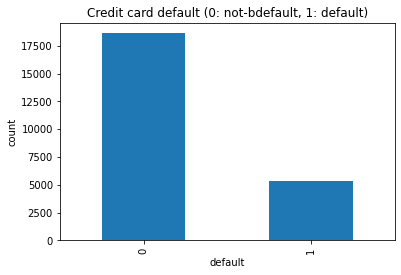

In [4]:
d['default'].value_counts().plot(kind='bar', title='Credit card default (0: not-bdefault, 1: default)', ylabel='count', xlabel='default')

Dataset imbalance
------------------

In [5]:
imbalance = d['default'].value_counts()
imbalance_perc = imbalance[1]/(imbalance[0]+imbalance[1])
imbalance_perc

0.2237176549022876

Dataset is not too imbalanced, 5:1 ratio seems to be OK for furthe analysis. In case of worse ratio, some strategies can be adopted: 
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

Column values validation
----------------------

In [6]:
d['sex'].value_counts()

2    15078
1     8921
Name: sex, dtype: int64

There are only two types of sex - OK

In [7]:
d['education'].value_counts()

2    11360
1     8442
3     3850
5      207
4       92
6       37
0       11
Name: education, dtype: int64

There are multiple education levels, according to dictionary it should be only 3 levels and then others: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown). Change levels 0, 4, 5 and 6 to others category. 

In [8]:
d['education'] = d['education'].replace({x:4 for x in [0, 5,6]})
d['education'].value_counts()

2    11360
1     8442
3     3850
4      347
Name: education, dtype: int64

**NOTE**: should be "others" category below *grad school* or higher than *high school*, i.e., should the category value be 0 or 4?

In [9]:
def correlate_columns(df: pd.DataFrame, col_a: str, col_b: str) -> pd.DataFrame:
    res = df.groupby([col_a, col_b]).size().unstack()
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [10]:
correlate_columns(d, 'education', 'default')

default,0,1,perc
education,,,
1,6791,1651,0.195570
2,8645,2715,0.238996
3,2869,981,0.254805
4,325,22,0.063401


Let's order education category by percentage of defaults: then *others* category should be 0.

In [11]:
d['education'] = d['education'].replace({x:0 for x in [0, 4, 5,6]})
correlate_columns(d, 'education', 'default')

default,0,1,perc
education,,,
0,325,22,0.063401
1,6791,1651,0.195570
2,8645,2715,0.238996
3,2869,981,0.254805


In [12]:
d['marriage'].value_counts()

2    12876
1    10813
3      269
0       41
Name: marriage, dtype: int64

Marriage status should be only (1=married, 2=single, 3=others), append unknown value of 0 to "others" category. 

In [13]:
d['marriage'] = d['marriage'].replace({0:3})
d['marriage'].value_counts()

2    12876
1    10813
3      310
Name: marriage, dtype: int64

**NOTE**: should be "others" category under or over marriage status?

In [14]:
correlate_columns(d, 'marriage', 'default')

default,0,1,perc
marriage,,,
1,8236,2577,0.238324
2,10156,2720,0.211246
3,238,72,0.232258


In [15]:
pays = []
for i in [1,2,3,4,5,6]:
    pays.append(d[f'pay_{i}'].value_counts())
pays = pd.concat(pays, axis=1)
pays

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
-2,2086,2953,3197,3382,3539.0,3818.0
-1,4624,4886,4787,4555,4482.0,4722.0
0,11732,12543,12576,13250,13520.0,12876.0
1,2995,20,4,2,NaN,NaN
2,2185,3204,3121,2515,2178.0,2324.0
3,255,268,183,158,147.0,158.0
4,67,76,64,55,71.0,37.0
5,18,21,17,29,11.0,9.0
6,10,9,21,5,3.0,16.0
7,8,18,27,46,47.0,37.0


<AxesSubplot:title={'center':'pay values comparison'}, xlabel='payment delay for x monts', ylabel='# of instances'>

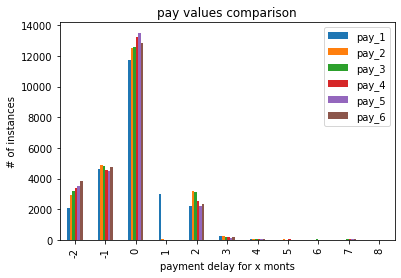

In [16]:
pays.plot(kind='bar', title='pay values comparison', ylabel='# of instances', xlabel='payment delay for x monts')

According to `dictionary.txt`, valid values for *pay_\** field are [-1, 1, 2, .., 9]. Additional values are present:
- 0: can be interpreted as "pay duly"?
- -2: no idea about interpretation

Moreover, very small amounts of values *1* in *pay_\** are suspicious. 
Let's see if we can make any sense from these values.

<AxesSubplot:xlabel='default', ylabel='pay values'>

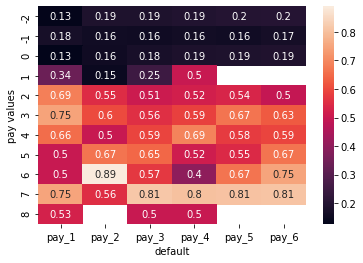

In [17]:
res = []
for col in [f'pay_{i}' for i in range(1,7)]:
    res.append(correlate_columns(d, col, 'default')[['perc']].rename(columns={'perc':col}))
res = pd.concat(res, axis=1)
res.index.name = 'pay values'
sns.heatmap(res, annot=True)

Values 0 and -2 in *pay_* * can be related to minimum paid. E.g.: the user only paid a minimum, paid more than minimum, repayed the whole sum. Corelation with *default* shows that values 0, -1 and -2 behave similarly and based of this assumption we will merge these values into one single value: 0. More elaborated analysis on meaning of *pay* and if time series of amounts (billing, payment) correspond can be elaborated.  

<AxesSubplot:xlabel='repayment', ylabel='value'>

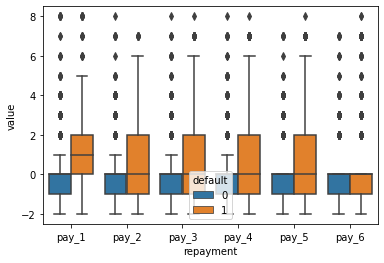

In [18]:
repayment = pd.melt(d[['default']+[f'pay_{i}' for i in range(1,7)]], id_vars='default', var_name='repayment', value_name='value')
sns.boxplot(y='value', x='repayment', hue='default', data=repayment)

Column *pay_1* seems to have large discriminative effect on default, boxplots do not overlap.

In [19]:
cols = [f'pay_{i}' for i in range(1,7)]
d[cols] = d[cols].mask(lambda x: x<0).fillna(0)